In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx

In [2]:
# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [3]:
# timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)


operator_name                          object
domain_name                            object
domain_id                               int64
counter_site                           object
counter_site_id                         int64
counter_serial                         object
longitude                             float64
latitude                              float64
timezone                               object
iso_timestamp             datetime64[ns, UTC]
channels_in                           float64
channels_out                          float64
channels_unknown                      float64
channels_all                            int64
site_temperature                      float64
site_rain_accumulation                float64
site_snow_accumulation                float64
dtype: object


In [4]:
# subset of dataframe just for tübi
df_tue = df_all[df_all["domain_name"] == "Stadt Tübingen"]
df_tue_grouped = df_tue.groupby("counter_site")

# get coordinates for every counter site in tüb
tue_coords = {
    name: (
        df_tue_grouped.get_group(name)["latitude"].iloc[0],
        df_tue_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_tue_grouped.groups.keys()
}
tue_coords

{'Fuß- & Radtunnel Südportal - Derendinger Allee': (np.float64(48.518),
  np.float64(9.04806)),
 'Neckartalradweg Hirschau - parallel L371': (np.float64(48.50357),
  np.float64(9.02496)),
 'Radbrücke Mitte - Wöhrdstraße': (np.float64(48.5178), np.float64(9.06091)),
 'Radbrücke Ost': (np.float64(48.51824), np.float64(9.06905)),
 'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': (np.float64(48.515434),
  np.float64(9.058865))}

In [5]:
# compute euclidian distance matrix between all counter sites in tüb
tue_sites = list(tue_coords.keys())
tue_dist_matrix = pd.DataFrame(index=tue_sites, columns=tue_sites)
for site_a in tue_sites:
    for site_b in tue_sites:
        coord_a = tue_coords[site_a]
        coord_b = tue_coords[site_b]
        dist = np.sqrt((coord_a[0] - coord_b[0])**2 + (coord_a[1] - coord_b[1])**2)
        tue_dist_matrix.loc[site_a, site_b] = dist

tue_dist_matrix = tue_dist_matrix.astype(float)
tue_dist_matrix

,Fuß- & Radtunnel Südportal - Derendinger Allee,Neckartalradweg Hirschau - parallel L371,Radbrücke Mitte - Wöhrdstraße,Radbrücke Ost,Unterführung Steinlach/Karlstraße Südseite - Steinlachallee
Fuß- & Radtunnel Südportal - Derendinger Allee,0.000000,0.027237,0.012852,0.020991,0.011106
Neckartalradweg Hirschau - parallel L371,0.027237,0.000000,0.038664,0.046467,0.035921
Radbrücke Mitte - Wöhrdstraße,0.012852,0.038664,0.000000,0.008152,0.003127
Radbrücke Ost,0.020991,0.046467,0.008152,0.000000,0.010564
Unterführung Steinlach/Karlstraße Südseite - Steinlachallee,0.011106,0.035921,0.003127,0.010564,0.000000


In [6]:
# set some coords as center point, e.g. fahrradtunnel
center_point = (48.518, 9.048)  

# access streetmaps graph with bike lanes, with radtunnel as cp and 3km radius
G = ox.graph_from_point(center_point, dist=3000, network_type='bike')

In [7]:
# nodes in our graph are our 5 counter sites 
snapped_nodes = {}
for name, (lat, lon) in tue_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [8]:
# now name the nodes and compute shortest distance by bike

distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        #print(f"distance between {i} and {j}: {d:.1f} m")


In [9]:
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        #ox.plot_graph_route(G, r)



- Heidelberg: 15 counter
- Stuttgart: 15 counter
- Ludwigsburg: 15 counter
- Mannheim: 14 counter
- Freiburg: 10 counter
- Reutlingen: 7 counter
- Konstanz: 6 counter
- Tübingen: 5 counter
- Heilbronn: 4 counter
- Lörrach: 2 counter


In [ ]:
# pivot table for correlation matrix
df_tue_pivot = df_tue.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_tue_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
overlap

counter_site,Fuß- & Radtunnel Südportal - Derendinger Allee,Neckartalradweg Hirschau - parallel L371,Radbrücke Mitte - Wöhrdstraße,Radbrücke Ost,Unterführung Steinlach/Karlstraße Südseite - Steinlachallee
counter_site,,,,,
Fuß- & Radtunnel Südportal - Derendinger Allee,108129,80252,23339,14778,105951
Neckartalradweg Hirschau - parallel L371,80252,80345,21460,12846,78129
Radbrücke Mitte - Wöhrdstraße,23339,21460,23394,14688,23069
Radbrücke Ost,14778,12846,14688,14780,14455
Unterführung Steinlach/Karlstraße Südseite - Steinlachallee,105951,78129,23069,14455,106894


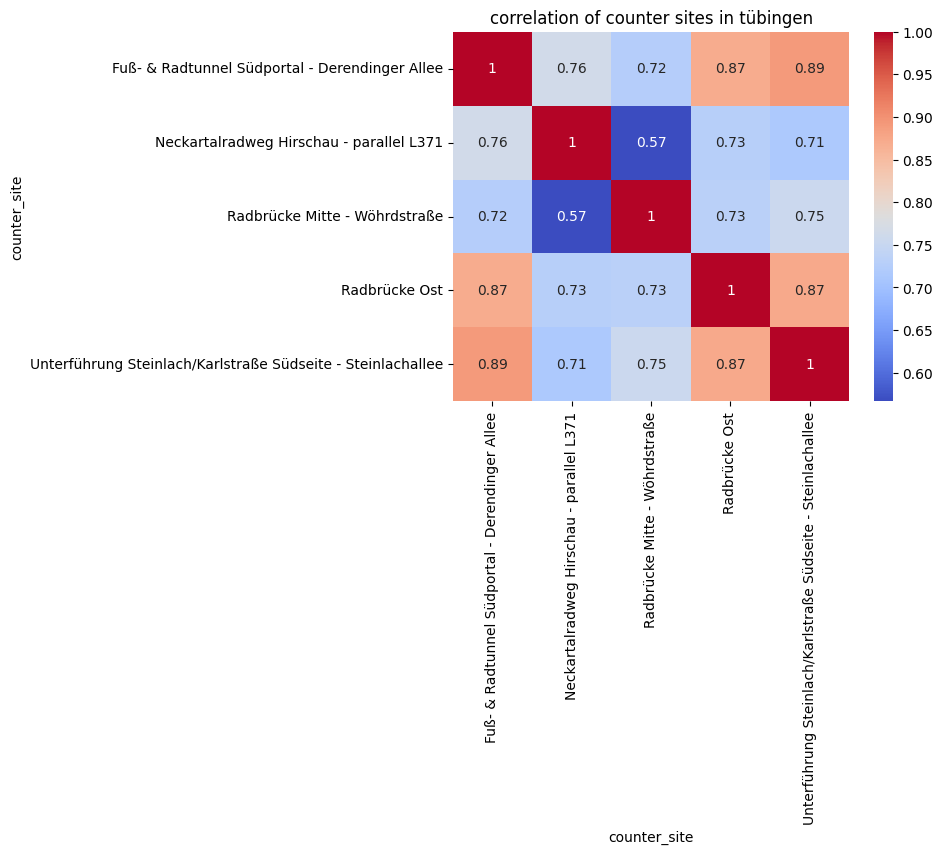

In [11]:
# compute correlation matrix and plot heatmap
corr_matrix = df_tue_pivot.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("correlation of counter sites in tübingen")
plt.show()

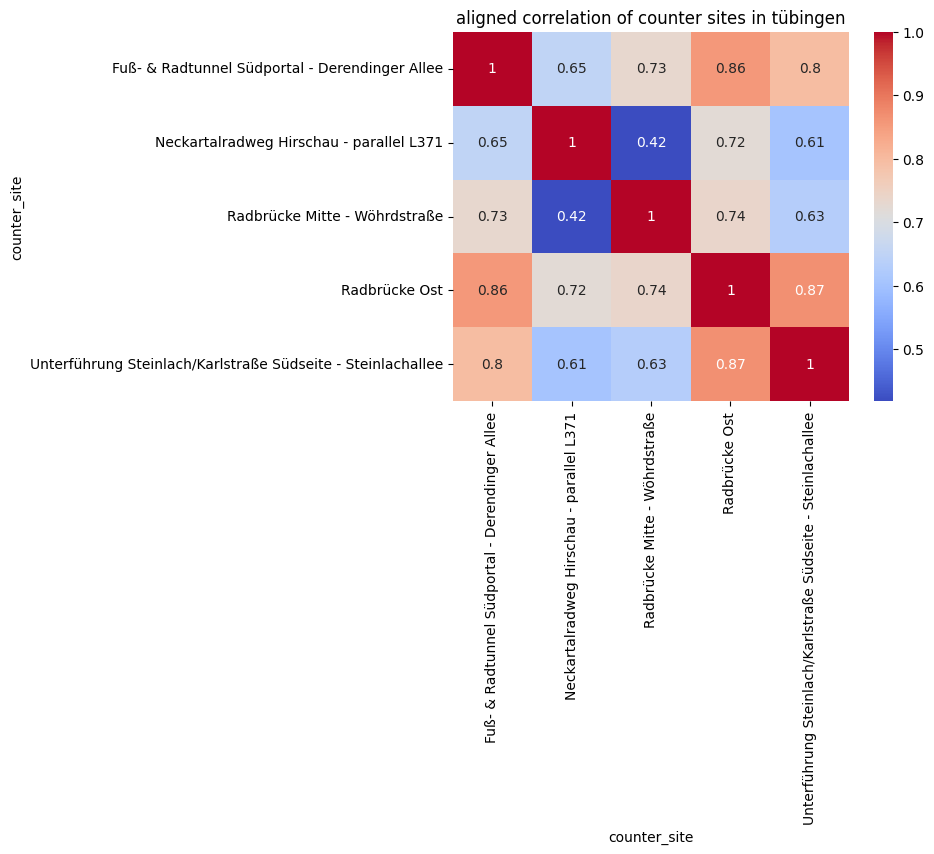

In [ ]:
# correlation matrix for just times where all sites have data
aligned = df_tue_pivot.dropna()
corr_matrix1 = aligned.corr()
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title("aligned correlation of counter sites in tübingen")
plt.show()

In [12]:
# save all sites in a list
sites1 = list(snapped_nodes.keys())

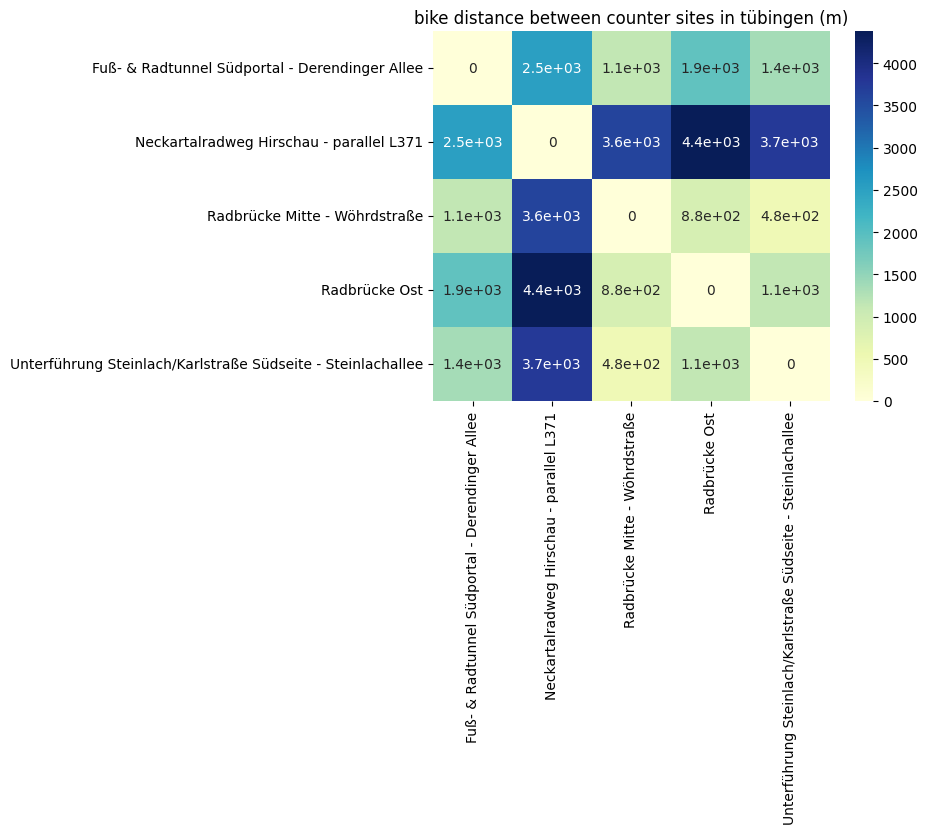

In [ ]:
# create distance matrix
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

# check shape
dist_matrix.shape

# heatmap for distances 
sns.heatmap(dist_matrix.astype(int), annot=True, cmap='YlGnBu')
plt.title("bike distance between counter sites in tübingen (m)")
plt.show()  

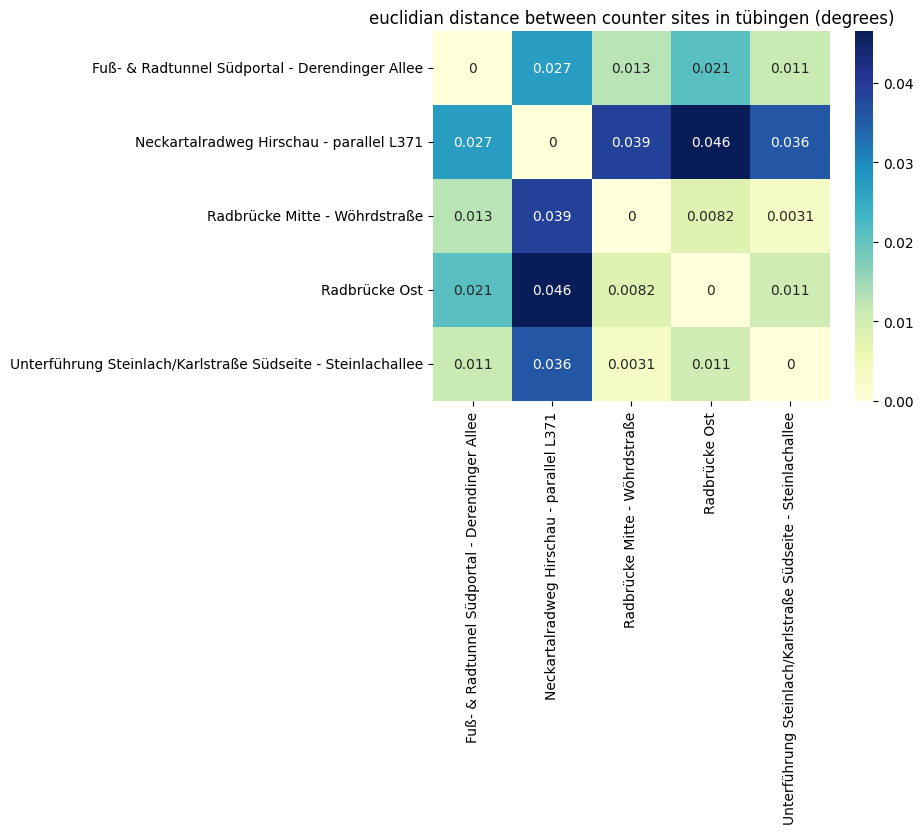

In [22]:
# now again for euclidian distances
sns.heatmap(tue_dist_matrix.astype(float), annot=True, cmap='YlGnBu')
plt.title("euclidian distance between counter sites in tübingen (degrees)")
plt.show()

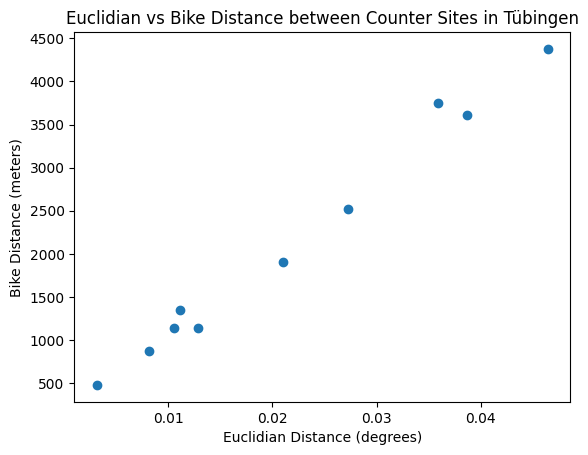

In [23]:
# euclidian vs bike distance scatter plot
euclidian_distances = []
bike_distances = []
for site_a in tue_sites:
    for site_b in tue_sites:
        if site_a >= site_b:
            continue
        euclidian_distances.append(tue_dist_matrix.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])
plt.scatter(euclidian_distances, bike_distances)
plt.xlabel("Euclidian Distance (degrees)")
plt.ylabel("Bike Distance (meters)")
plt.title("Euclidian vs Bike Distance between Counter Sites in Tübingen")
plt.show()

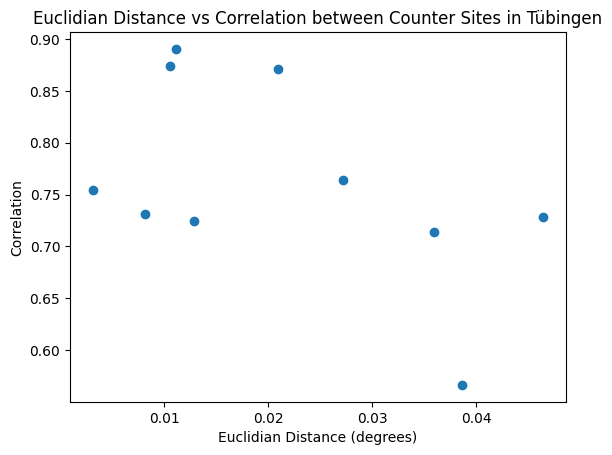

In [25]:
# euclidian distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = tue_dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

plt.scatter(distance_values, correlations)
plt.xlabel("Euclidian Distance (degrees)")
plt.ylabel("Correlation")
plt.title("Euclidian Distance vs Correlation between Counter Sites in Tübingen")
plt.show()

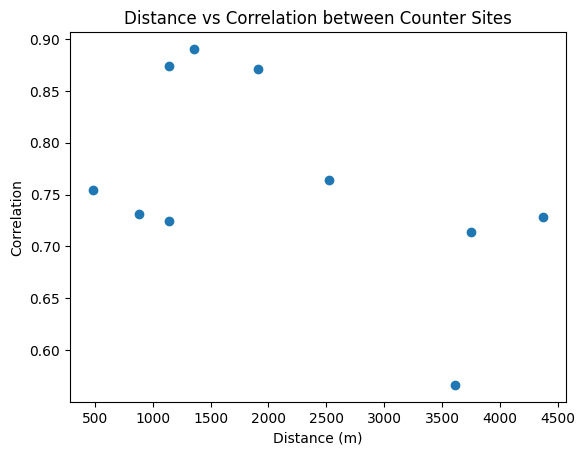

In [24]:
# distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title("Distance vs Correlation between Counter Sites")
plt.show()